# 06 - Predicting Electric Consumption Data with Spark ML-Lib

**Author:** Adrián Romero Flores  
**Repository:** [link](https://github.com/adrrf/bigdata/tree/main/05-spark-sql)

---

## Overview

1. [Introduction](#introduction)  
2. [Environment Setup](#environment)  
3. [Data Loading](#data-loading)  
4. [Unsupervised Learning](#unsupervised-learning)  
5. [Supervised Learning](#supervised-learning)  
6. [Results and Conclusions](#results-and-conclusions)

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
# define the struct of types
schema = StructType([
    StructField("IDENTIFICADOR", StringType(), True),
    StructField("ANOMES", StringType(), True),
    StructField("CNAE", StringType(), True),
    StructField("PRODUCTO", StringType(), True),
    StructField("MERCADO", StringType(), True),
    StructField("ACTIVA_H1", DoubleType(), True),
    StructField("ACTIVA_H2", DoubleType(), True),
    StructField("ACTIVA_H3", DoubleType(), True),
    StructField("ACTIVA_H4", DoubleType(), True),
    StructField("ACTIVA_H5", DoubleType(), True),
    StructField("ACTIVA_H6", DoubleType(), True),
    StructField("ACTIVA_H7", DoubleType(), True),
    StructField("ACTIVA_H8", DoubleType(), True),
    StructField("ACTIVA_H9", DoubleType(), True),
    StructField("ACTIVA_H10", DoubleType(), True),
    StructField("ACTIVA_H11", DoubleType(), True),
    StructField("ACTIVA_H12", DoubleType(), True),
    StructField("ACTIVA_H13", DoubleType(), True),
    StructField("ACTIVA_H14", DoubleType(), True),
    StructField("ACTIVA_H15", DoubleType(), True),
    StructField("ACTIVA_H16", DoubleType(), True),
    StructField("ACTIVA_H17", DoubleType(), True),
    StructField("ACTIVA_H18", DoubleType(), True),
    StructField("ACTIVA_H19", DoubleType(), True),
    StructField("ACTIVA_H20", DoubleType(), True),
    StructField("ACTIVA_H21", DoubleType(), True),
    StructField("ACTIVA_H22", DoubleType(), True),
    StructField("ACTIVA_H23", DoubleType(), True),
    StructField("ACTIVA_H24", DoubleType(), True),
    StructField("ACTIVA_H25", DoubleType(), True),
    StructField("REACTIVA_H1", DoubleType(), True),
    StructField("REACTIVA_H2", DoubleType(), True),
    StructField("REACTIVA_H3", DoubleType(), True),
    StructField("REACTIVA_H4", DoubleType(), True),
    StructField("REACTIVA_H5", DoubleType(), True),
    StructField("REACTIVA_H6", DoubleType(), True),
    StructField("REACTIVA_H7", DoubleType(), True),
    StructField("REACTIVA_H8", DoubleType(), True),
    StructField("REACTIVA_H9", DoubleType(), True),
    StructField("REACTIVA_H10", DoubleType(), True),
    StructField("REACTIVA_H11", DoubleType(), True),
    StructField("REACTIVA_H12", DoubleType(), True),
    StructField("REACTIVA_H13", DoubleType(), True),
    StructField("REACTIVA_H14", DoubleType(), True),
    StructField("REACTIVA_H15", DoubleType(), True),
    StructField("REACTIVA_H16", DoubleType(), True),
    StructField("REACTIVA_H17", DoubleType(), True),
    StructField("REACTIVA_H18", DoubleType(), True),
    StructField("REACTIVA_H19", DoubleType(), True),
    StructField("REACTIVA_H20", DoubleType(), True),
    StructField("REACTIVA_H21", DoubleType(), True),
    StructField("REACTIVA_H22", DoubleType(), True),
    StructField("REACTIVA_H23", DoubleType(), True),
    StructField("REACTIVA_H24", DoubleType(), True),
    StructField("REACTIVA_H25", DoubleType(), True)
])
# read csv without header
df = spark.read.csv("/FileStore/tables/endesaAgregada.csv", header=False, schema=schema)

In [0]:
# let's remove the ACTIVA_H25 column
df = df.drop("ACTIVA_H25")
# let's remove all REACTIVA_HX columns
reactiva_columns = [f"REACTIVA_H{i}" for i in range(1, 25)]

df = df.drop(*reactiva_columns)
print(f"columns after removal: {len(df.columns)} columns")

columns after removal: 30 columns


In [0]:
activa_columns = [f"ACTIVA_H{i}" for i in range(1, 25)]
df_negatives = df.filter(
    " OR ".join([f"{columna} < 0" for columna in activa_columns])
)
print(f"number of rows with negative values: {df_negatives.count()}")
df = df.subtract(df_negatives)

number of rows with negative values: 4


In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

indexers = [
    StringIndexer(inputCol="CNAE", outputCol="CNAE_index"),
    StringIndexer(inputCol="MERCADO", outputCol="MERCADO_index")
]

features = [f"ACTIVA_H{i}" for i in range(1, 25)] + ["CNAE_index", "MERCADO_index"]
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

costs = []
for k in range(2, 11):
    print("try k = ", k)
    kmeans = KMeans(featuresCol="features", k=k)
    pipeline = Pipeline(stages=indexers + [assembler, kmeans])
    model = pipeline.fit(df)
    wssse = model.stages[-1].summary.trainingCost
    costs.append((k, wssse))

try k =  2
try k =  3
try k =  4
try k =  5
try k =  6
try k =  7
try k =  8
try k =  9
try k =  10


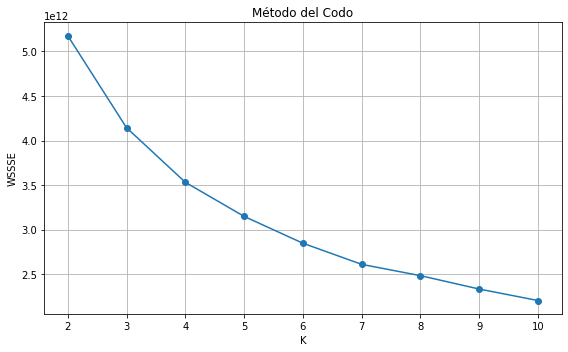

In [0]:
import matplotlib.pyplot as plt

ks, wssses = zip(*costs)

plt.figure(figsize=(8, 5))
plt.plot(ks, wssses, marker='o')
plt.title("Método del Codo")
plt.xlabel("K")
plt.ylabel("WSSSE")
plt.grid(True)
plt.xticks(ks)
plt.tight_layout()
plt.show()

In [0]:
kmeans = KMeans(featuresCol="features", k=3)
pipeline = Pipeline(stages=indexers + [assembler, kmeans])
model = pipeline.fit(df)
kmeans_model = model.stages[-1]

In [0]:
df_clustered = model.transform(df)

In [0]:
import pandas as pd
import numpy as np

centers = kmeans_model.clusterCenters()
columns = assembler.getInputCols()
centroids_df = pd.DataFrame(centers, columns=columns)
centroids_df.index.name = 'Cluster'
centroids_df

,ACTIVA_H1,ACTIVA_H2,ACTIVA_H3,ACTIVA_H4,ACTIVA_H5,ACTIVA_H6,ACTIVA_H7,ACTIVA_H8,ACTIVA_H9,ACTIVA_H10,...,ACTIVA_H17,ACTIVA_H18,ACTIVA_H19,ACTIVA_H20,ACTIVA_H21,ACTIVA_H22,ACTIVA_H23,ACTIVA_H24,CNAE_index,MERCADO_index
Cluster,,,,,,,,,,,,,,,,,,,,,
0,166.981780,130.350278,112.267700,103.801835,100.187643,100.907454,111.443311,140.905150,160.376036,167.756293,...,196.396317,196.879076,207.463244,223.814557,255.991685,289.525240,268.761722,219.736167,0.148214,0.412913
1,5157.807685,4831.957527,4642.150040,4505.185697,4443.671968,4445.333465,4423.716812,3906.462861,3526.905373,3727.496543,...,3577.209502,3649.635421,4150.790597,4715.949921,5049.699230,5538.475603,5819.777262,5565.639964,0.836428,0.745950
2,848.239871,702.614470,622.487083,581.998327,566.463654,577.885181,612.756669,719.496877,887.326039,1090.359389,...,1124.267048,1248.730034,1333.167379,1384.195079,1329.434517,1285.664274,1211.423103,1045.233452,0.402948,0.527923


In [0]:
indexer = StringIndexer(inputCol="CNAE", outputCol="label")

features = [f"ACTIVA_H{i}" for i in range(1, 25)]

assembler = VectorAssembler(inputCols=features, outputCol="features")

pipeline_prep = Pipeline(stages=[indexer, assembler])

df_prepared = pipeline_prep.fit(df).transform(df)

In [0]:
train, test = df_prepared.randomSplit([0.8, 0.2], seed=33)

In [0]:
from pyspark.ml.classification import (
    RandomForestClassifier,
    GBTClassifier,
    LogisticRegression,
    DecisionTreeClassifier
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

models = {
    "RandomForest": RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50),
    "GBT": GBTClassifier(labelCol="label", featuresCol="features", maxIter=50),
    "DecisionTree": DecisionTreeClassifier(labelCol="label", featuresCol="features"),
    "LogisticRegression": LogisticRegression(labelCol="label", featuresCol="features", maxIter=100)
}

results = {}

for name, classifier in models.items():
    model = classifier.fit(train)
    predictions = model.transform(test)
    f1 = evaluator.evaluate(predictions)
    results[name] = f1
    print(f"{name}: F1 score = {f1:.4f}")


RandomForest: F1 score = 0.8090
GBT: F1 score = 0.8542
DecisionTree: F1 score = 0.8361
LogisticRegression: F1 score = 0.8056


In [0]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50)
model = gbt.fit(train)

importances = model.featureImportances.toArray()
feature_names = assembler.getInputCols()

feature_importance = list(zip(feature_names, importances))

for name, score in sorted(feature_importance, key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.4f}")

ACTIVA_H12: 0.1230
ACTIVA_H23: 0.1042
ACTIVA_H13: 0.1006
ACTIVA_H24: 0.0947
ACTIVA_H16: 0.0800
ACTIVA_H22: 0.0672
ACTIVA_H5: 0.0542
ACTIVA_H6: 0.0530
ACTIVA_H7: 0.0527
ACTIVA_H19: 0.0365
ACTIVA_H8: 0.0345
ACTIVA_H2: 0.0258
ACTIVA_H20: 0.0244
ACTIVA_H11: 0.0230
ACTIVA_H15: 0.0222
ACTIVA_H4: 0.0165
ACTIVA_H10: 0.0146
ACTIVA_H9: 0.0144
ACTIVA_H21: 0.0128
ACTIVA_H17: 0.0125
ACTIVA_H1: 0.0124
ACTIVA_H3: 0.0094
ACTIVA_H18: 0.0072
ACTIVA_H14: 0.0043
